Mario Bello - Miguel Bielsa - Marta Pascual - María Sancho


#**EJERCICIO 1: ANÁLISIS DEL CONJUNTO DE DATOS**

A lo largo de este primer cuaderno, se va a realizar un análisis preliminar de la base de datos con la que se va a trabajar. El objetivo es comprender las partes de las que se compone, así como comentar algunas primeras observaciones e hipótesis previas que sirvan para introducir el grueso del trabajo que se presentará en el segundo cuaderno.

In [52]:
# Importamos todas las librerías a utilizar en este primer cuaderno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

En un primer lugar, cargamos la base de datos y realizamos un breve estudio de las noticias que tenemos, cuántas tenemos de cada tipo (*True*/*False*), etc.

In [53]:
# Cargar el conjunto de datos
dataset = pd.read_excel('fake_new_dataset.xlsx')

print("=" * 60)
print("DESCRIPCIÓN GENERAL DEL DATASET")
print("=" * 60)

print(f"\nNúmero de instancias:{dataset.shape[0]}")
print(f"Número de variables:{dataset.shape[1]}")
print(f"\nColumnas:{dataset.columns.tolist()}")

print("\n--- Tipos de datos ---")
print(dataset.dtypes)

print("\n--- Valores nulos ---")
print(dataset.isnull().sum())

print("\n--- Ejemplos de noticias del dataset ---")
print(dataset.head(3))

DESCRIPCIÓN GENERAL DEL DATASET

Número de instancias:3119
Número de variables:5

Columnas:['Unnamed: 0', 'title', 'text', 'subcategory', 'label']

--- Tipos de datos ---
Unnamed: 0      int64
title          object
text           object
subcategory    object
label           int64
dtype: object

--- Valores nulos ---
Unnamed: 0     0
title          1
text           0
subcategory    0
label          0
dtype: int64

--- Ejemplos de noticias del dataset ---
   Unnamed: 0                                              title  \
0           0  FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...   
1           1   Other Viewpoints: COVID-19 is worse than the flu   
2           2               Bermuda's COVID-19 cases surpass 100   

                                                text subcategory  label  
0  Facebook has shuttered a popular group for Mic...  false news      0  
1  We can now officially put to rest all comparis...        true      1  
2  The Ministry of Health in Bermuda has confir

Tenemos un total de 3119 noticias, para cada una de las cuales se diferencian 5 columnas. Las más relevantes y que utilizaremos a lo largo del trabajo son:

- 'text': Incluye el cuerpo de la noticia.
- 'subcategory': Diferencia entre noticias *True*/*False* y *Partially False*.
- 'label': Agrupa las categorías de *False* y *Partially False* para dejar una clasificación binaria (*True*=1/*False*=0).

A lo largo del trabajo se irá trabajando tanto con las etiquetas marcadas por 'label' (clasificación binaria) como con las indicadas por 'subcategory', que incluye una clase más. Para cada caso, se comentarán las diferencias encontradas y con cuál de las dos opciones se obtienen los mejores resultados, aunque a priori, las prestaciones deberían ser mejores con tan solo 2 etiquetas (agrupando *False* y *Partially False*).

Pasamos al siguiente punto para comprender cómo se distribuyen las noticias entre las 3 clases (*True*/*False*/*Partially False*), para saber con cuantas instancias de cada clase cuenta nuestra base de datos.


DISTRIBUCIÓN DE CLASES

--- Frecuencia por clase (label) ---
0 (False/Partially False): 1058
  - False: 659
  - Partially False: 399
1 (True): 2061

Porcentaje:
0 (False/Partially False): 33.92%
1 (True): 66.08%


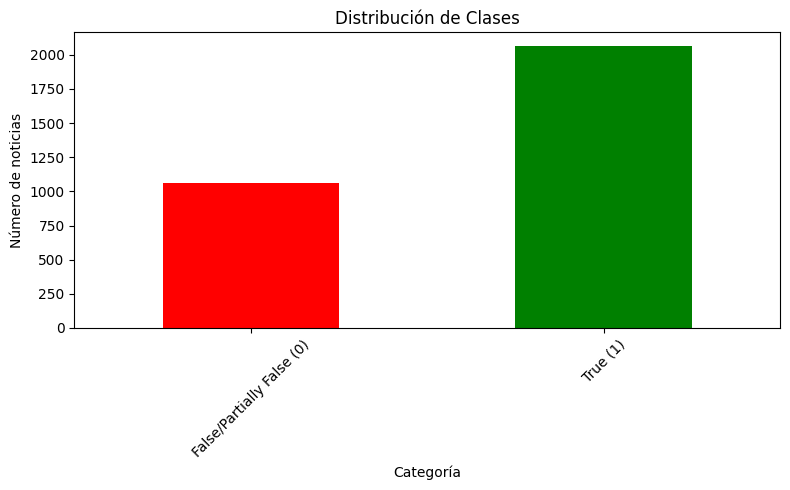

In [54]:
print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 60)

print("\n--- Frecuencia por clase (label) ---")
print(f"0 (False/Partially False): {(dataset['label'] == 0).sum()}")
print(f"  - False: {str(np.sum(dataset['subcategory']=="false news"))}")
print(f"  - Partially False: {str(np.sum(dataset['subcategory']=="partially false"))}")
print(f"1 (True): {(dataset['label'] == 1).sum()}")

# Porcentaje de noticias verdaderas y falsas
print(f"\nPorcentaje:")
print(f"0 (False/Partially False): {(dataset['label'] == 0).sum() / len(dataset) * 100:.2f}%")
print(f"1 (True): {(dataset['label'] == 1).sum() / len(dataset) * 100:.2f}%")

# Gráfico de distribución
plt.figure(figsize=(8, 5))
dataset['label'].value_counts().sort_index().plot(kind='bar', color=['red', 'green'])
plt.title('Distribución de Clases')
plt.xlabel('Categoría')
plt.ylabel('Número de noticias')
plt.xticks([0, 1], ['False/Partially False (0)', 'True (1)'], rotation=45)
plt.tight_layout()
plt.show()

Se puede ver en el histograma que el número de noticias verdaderas (*True*) supera con creces las noticias falsas (*False/Partially False*) con casi el doble de noticias. Es decir, de cara a futuros ejercicios, deberemos tener cuidado a la hora de dividir en train/test y validación para que todos los subconjuntos contengan muestras de todas las categorías.

Por otra parte, esta división desigual refuerza la idea que antes se comentaba de simplificar la división de noticias entre *True* y *False*, suprimiendo la categoría de *Partially False*. Esto es porque, viendo que las noticias *True* suponen en torno al 66% del database, si del 34% restante aún efectuamos otra partición, el número de muestras que quedarán para entrenar, validar y testear las clases minoritarias será demasiado pequeño.

Una vez vista y entendida la estructura de la base de datos, a continuación se presentan las estadísticas de longitud de las noticias en términos de palabras y caracteres.


ANÁLISIS DE LONGITUD DE TEXTO

--- Estadísticas de longitud ---
        text_length   word_count
count   3119.000000  3119.000000
mean    3103.330555   502.348830
std     3128.270583   507.686093
min      105.000000    18.000000
25%     1383.000000   227.000000
50%     2256.000000   365.000000
75%     3657.000000   590.000000
max    32767.000000  5469.000000

--- Longitud promedio por clase ---
       text_length  word_count
label                         
0      3694.546314  602.611531
1      2799.834061  450.879670


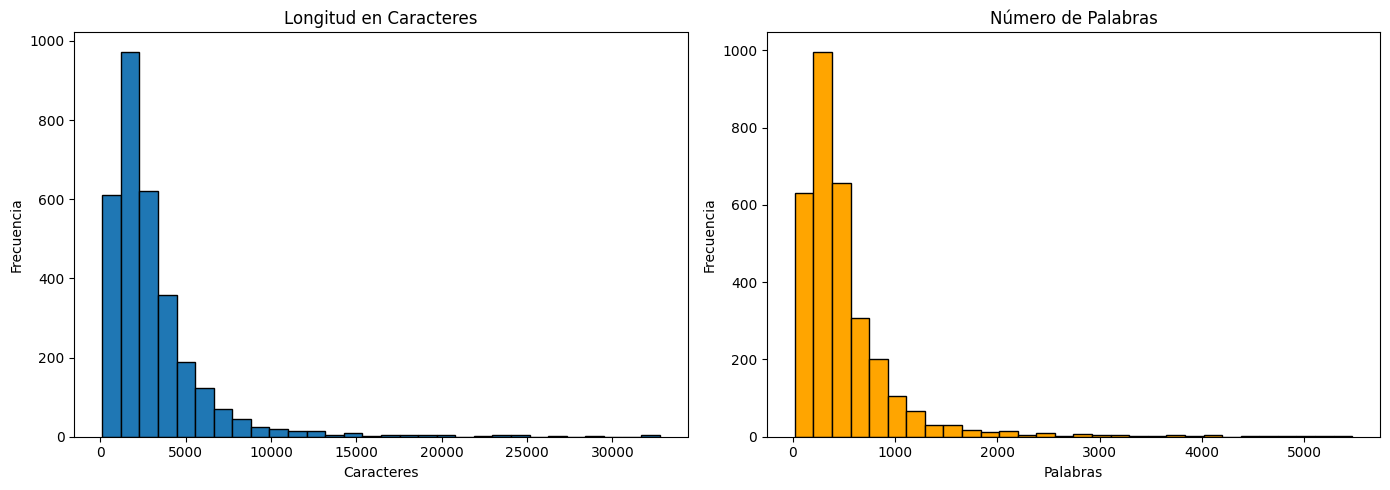

In [55]:
print("\n" + "=" * 60)
print("ANÁLISIS DE LONGITUD DE TEXTO")
print("=" * 60)

dataset['text_length'] = dataset['text'].astype(str).apply(len)
dataset['word_count'] = dataset['text'].astype(str).apply(lambda x: len(x.split()))

print("\n--- Estadísticas de longitud ---")
print(dataset[['text_length', 'word_count']].describe())

# Comparación por clase
print("\n--- Longitud promedio por clase ---")
print(dataset.groupby('label')[['text_length', 'word_count']].mean())

# Gráficos de longitud
fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].hist(dataset['text_length'], bins=30, edgecolor='black')
axes[0].set_title('Longitud en Caracteres')
axes[0].set_xlabel('Caracteres')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(dataset['word_count'], bins=30, edgecolor='black', color='orange')
axes[1].set_title('Número de Palabras')
axes[1].set_xlabel('Palabras')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

En estas estadísticas podemos ver cosas importantes para el resto del trabajo. Para empezar, podemos ver la distribución en número de palabras y caracteres de las noticias en nuestra base de datos. Con el percentil del 50% vemos que la mitad de las noticias contienen más de 2256 caracteres (365 palabras), y solo el 25% está por debajo de 227 palabras, es decir, que en general las noticias que tenemos son largas, con un máximo de hasta 5469 palabras (como referencia, articulos profundos de periódicos digitales pueden alcanzar unas 4000 palabras).

Si nos fijamos en la longitud media por clase (*True*/*False*), vemos como las noticias verdaderas (etiqueta 1) son de media unas 150 palabras más cortas. Es decir, que aunque el número de noticias falsas es menor (como veíamos antes), son considerablemente más largas, aunque esto no tiene por qué tener ninguna repercusión positiva para nuestro clasificador.

Ya hemos visto la cantidad de palabras/caracteres de cada noticia, y toca mirar ahora cuáles son las palabras más comunes en el conjunto del dataset.


PALABRAS MÁS FRECUENTES

--- Top 15 palabras ---
the: 95854
of: 45408
to: 44836
and: 42235
in: 35114
a: 27753
is: 18881
that: 17026
for: 14534
on: 12485
with: 12352
are: 11686
virus: 11177
from: 10895
as: 10460


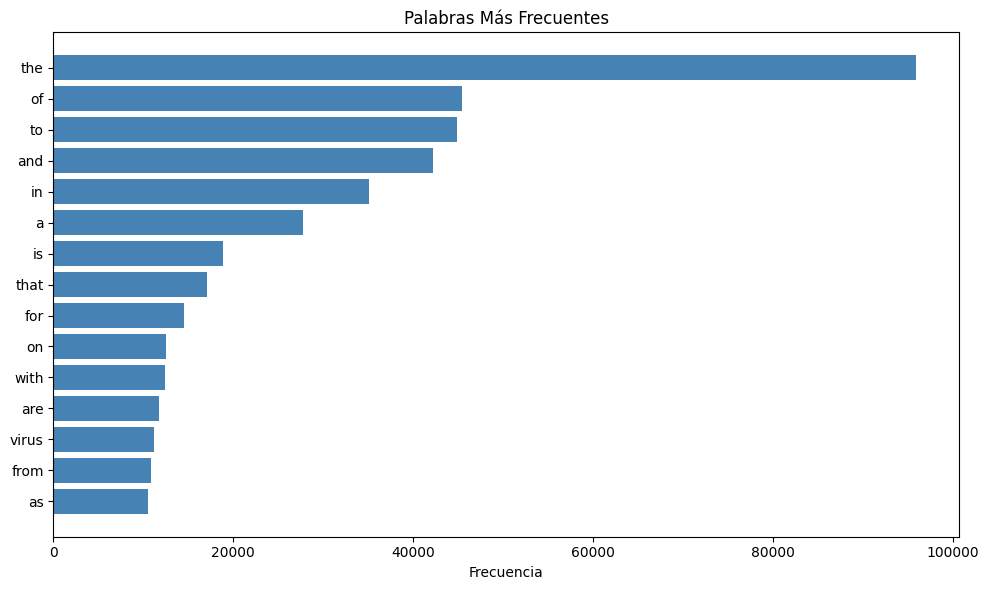

In [56]:
print("\n" + "=" * 60)
print("PALABRAS MÁS FRECUENTES")
print("=" * 60)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

all_text = ' '.join(dataset['text'].astype(str).apply(clean_text))
words = all_text.split()

# Contamos las palabras y nos quedamos con las 15 más comunes
word_frecuency = Counter(words)
most_common_words = word_frecuency.most_common(15)

print("\n--- Top 15 palabras ---")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Gráfico de palabras frecuentes
words_df = pd.DataFrame(most_common_words, columns=['Palabra', 'Frecuencia'])
plt.figure(figsize=(10, 6))
plt.barh(words_df['Palabra'], words_df['Frecuencia'], color='steelblue')
plt.xlabel('Frecuencia')
plt.title('Palabras Más Frecuentes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Como era de esperar, las palabras más cortas, que incluyen preposiciones y conectores son las más comunes en nuestra base de datos. La mayor parte de estas palabras en realidad no aportan demasiada información para nuestro clasificador e incluso se pueden calificar como 'ruido'.

Para los siguientes ejercicios, esto es algo que se debe tener en cuenta, pues puede resultar interesante filtrar estas palabras cortas o demasiado repetidas que no contribuyan al correcto funcionamiento del clasificador.


NUBE DE PALABRAS


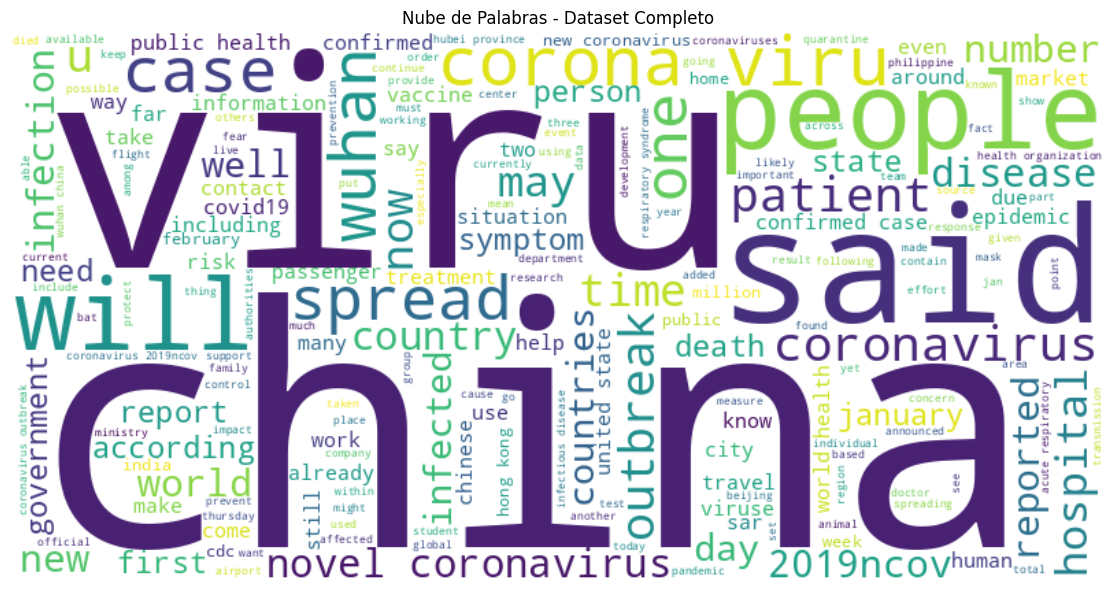

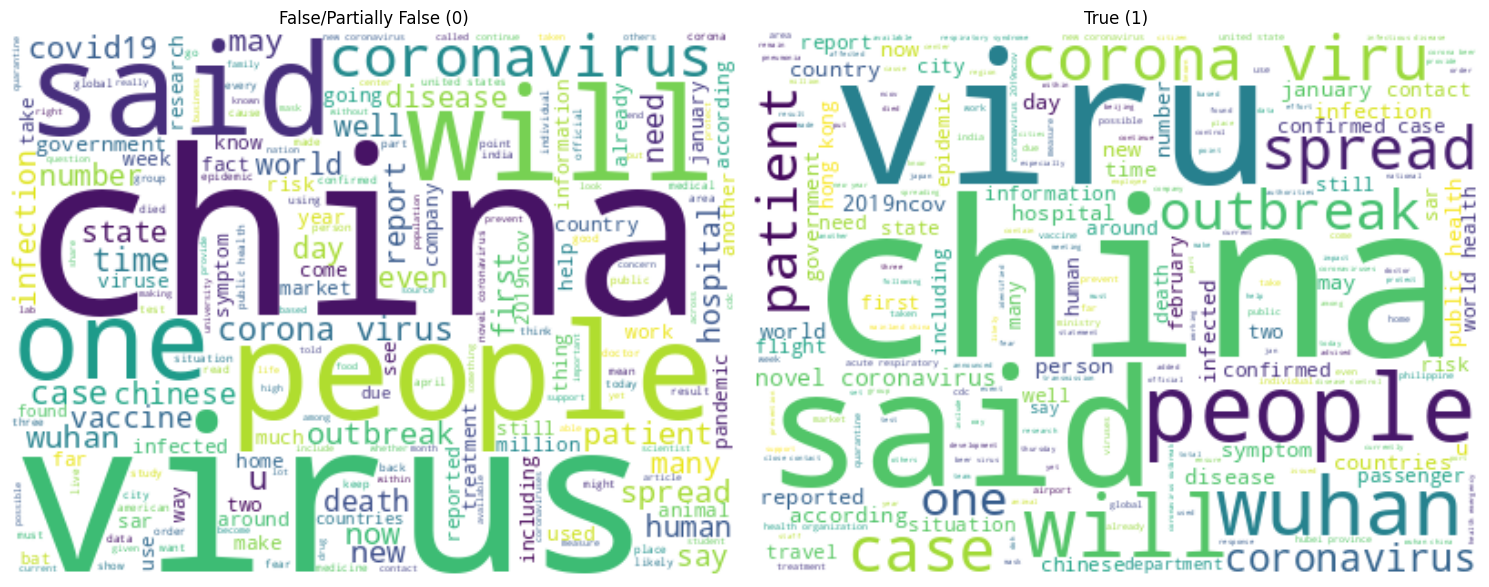

In [57]:
print("\n" + "=" * 60)
print("NUBE DE PALABRAS")
print("=" * 60)

# Nube general
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Dataset Completo')
plt.tight_layout()
plt.show()

# Nubes por clase
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Clase 0 (False/Partially False)
text_false = ' '.join(dataset[dataset['label'] == 0]['text'].astype(str).apply(clean_text))
wordcloud_false = WordCloud(width=400, height=300, background_color='white').generate(text_false)
axes[0].imshow(wordcloud_false, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('False/Partially False (0)')

# Clase 1 (True)
text_true = ' '.join(dataset[dataset['label'] == 1]['text'].astype(str).apply(clean_text))
wordcloud_true = WordCloud(width=400, height=300, background_color='white').generate(text_true)
axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('True (1)')

plt.tight_layout()
plt.show()

Obervando esta nube de palabras, podemos darnos cuenta de un detalle menor, pero puede que de gran importancia. En las noticias verdaderas, por alguna razón, las palabras *virus* y *coronavirus* aparecen sin 's' (*viru* y *coronaviru*) con mucha más frecuencia que con la 's'. Por lo tanto, a la hora de limpiar y homogeneizar el texto, deberemos, primero de todo, corregir este error.

Si no lo hiciéramos, es posible que nuestros modelos de clasificación, redes neuronales, etc. aprendieran que cuando aparece *viru* o *coronaviru* la noticia es verdadera, y sino es falsa, cosa que no queremos que ocurra, ya que no es ni mucho menos un indicativo de veracidad de la noticia.

Si corregimos estos errores, el resultado es el siguiente:

In [58]:
# Reemplazamos las palabras viru y coronaviru por virus y coronavirus

# (Este código deberá añadirse en el segundo cuaderno antes de realizar cualquier tipo de análisis)
correcciones = {
    r'\bviru\b': 'virus',
    r'\bcoronaviru\b': 'coronavirus'
}

for wrong, correct in correcciones.items():
    dataset ['text'] = dataset['text'].str.replace(wrong, correct, regex=True)

all_text = ' '.join(dataset['text'].astype(str).apply(clean_text))


NUBE DE PALABRAS


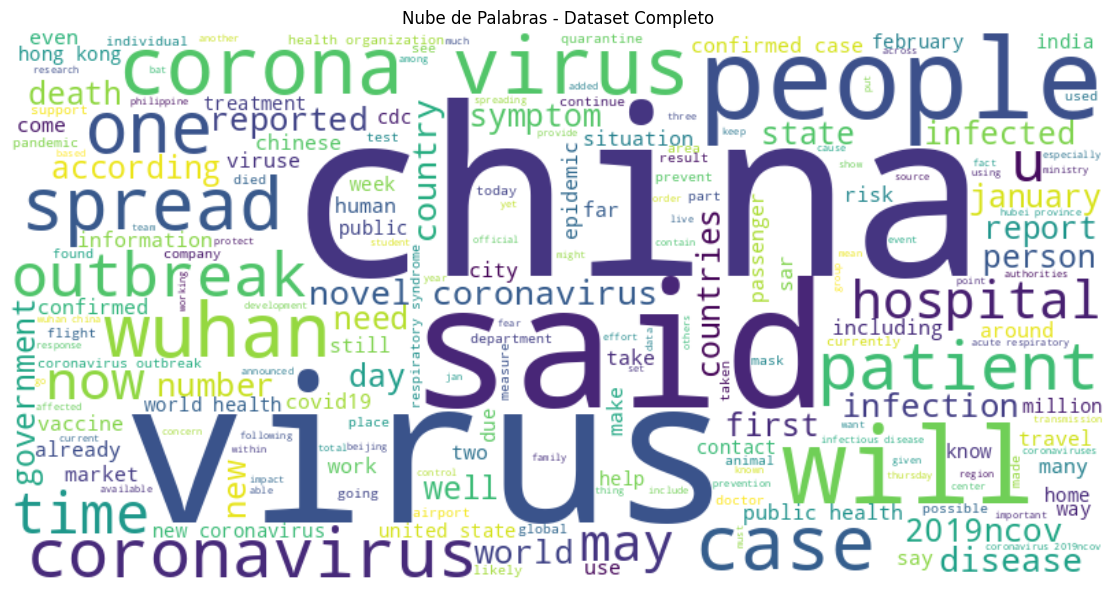

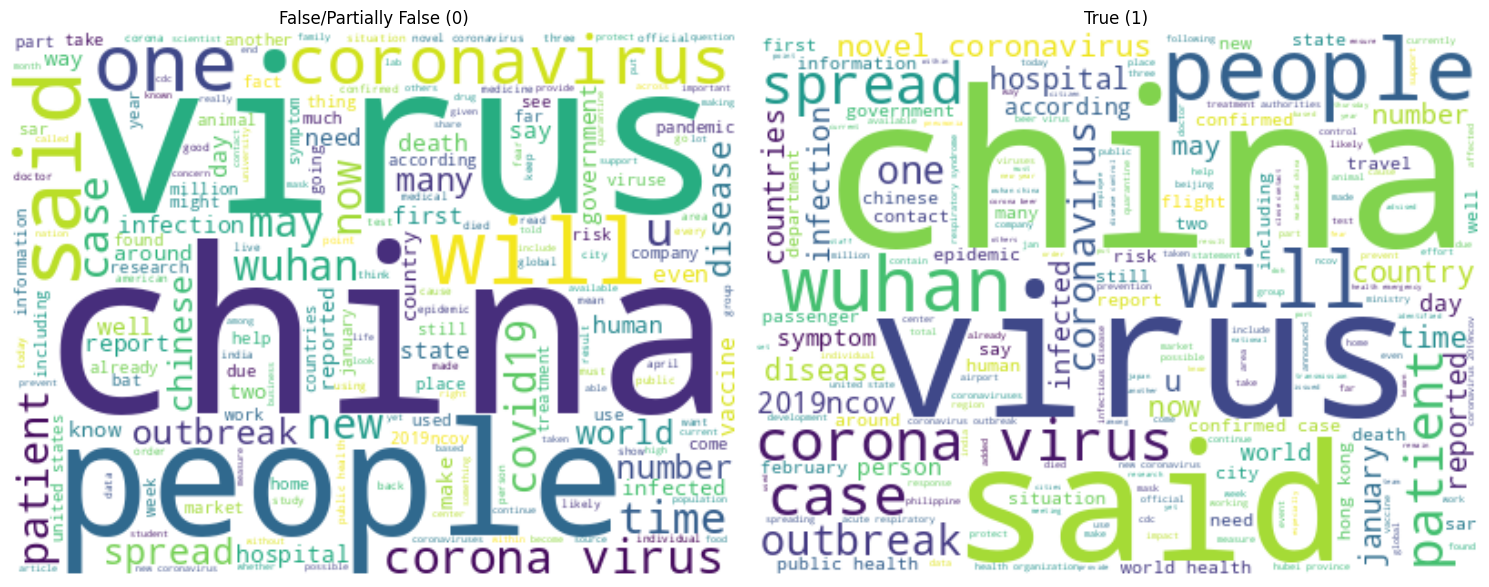

In [59]:
print("\n" + "=" * 60)
print("NUBE DE PALABRAS")
print("=" * 60)

# Nube general
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Dataset Completo')
plt.tight_layout()
plt.show()

# Nubes por clase
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Clase 0 (False/Partially False)
text_false = ' '.join(dataset[dataset['label'] == 0]['text'].astype(str).apply(clean_text))
wordcloud_false = WordCloud(width=400, height=300, background_color='white').generate(text_false)
axes[0].imshow(wordcloud_false, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('False/Partially False (0)')

# Clase 1 (True)
text_true = ' '.join(dataset[dataset['label'] == 1]['text'].astype(str).apply(clean_text))
wordcloud_true = WordCloud(width=400, height=300, background_color='white').generate(text_true)
axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('True (1)')

plt.tight_layout()
plt.show()

Se puede observar como ahora, han desaparecido las palabras que no queríamos y que podrían haber llevado a confusiones durante los modelos de clasificación del segundo cuaderno.

En cuanto a palabras clave que puedan caracterizar si una noticia es verdadera o falsa, a simple vista no se puede extraer ninguna hipótesis inicial, pues las palabras son similares para todos los casos (*china*, *people*, etc.). Por otra parte, las noticias falsas suelen tener un sentimiento más negativo o catastrofista, pero nuevamente no podemos identificar a simple vista esta polarización en el sentimiento entre noticias verdaderas y falsas.

Finalmente, se muestran algunas noticias a modo de ejemplo para ambas etiquetas (*True* o *False*/*Partially False*).

In [60]:
print("\n" + "=" * 60)
print("EJEMPLOS POR CLASE")
print("=" * 60)

# Mapear etiquetas
label_names = {0: 'FALSE/PARTIALLY FALSE', 1: 'TRUE'}

for clase in [0, 1]:
    print(f"\n--- {label_names[clase]} ---")
    ejemplos = dataset[dataset['label'] == clase]['text'].head(2)
    for i, ejemplo in enumerate(ejemplos, 1):
        print(f"\nEjemplo {i}:")
        print(str(ejemplo)[:200] + "...")


EJEMPLOS POR CLASE

--- FALSE/PARTIALLY FALSE ---

Ejemplo 1:
Facebook has shuttered a popular group for Michiganders who oppose their governor’s extreme lockdown measures, fueling debate about free speech during the coronavirus crisis.

‘Michiganders Against Ex...

Ejemplo 2:
Purdue University President Mitch Daniels, the former governor of Indiana, said in an April 21 letter he intends to open the West Lafayette, Indiana university for in-person classes in the fall, citin...

--- TRUE ---

Ejemplo 1:
We can now officially put to rest all comparisons of COVID-19 to influenza. Coronavirus is killing more Americans than the flu and almost everything else. According to data compiled by the Washington ...

Ejemplo 2:
The Ministry of Health in Bermuda has confirmed a newspaper report that 10 residents from the Westmeath Residential and Nursing Home had tested positive for COVID-19, taking the island’s total confirm...
